In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt

import nltk 
from nltk.stem import WordNetLemmatizer

import re
import codecs
import unidecode

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras import layers



# Import data

In [2]:
train = pd.read_csv('sentiment_train.csv', names=['index','text','sentiment'], header=0)
train.drop('index', axis=1, inplace=True)
train

,text,sentiment
0,⚠️ #TLUpdates - Due to a safety inspection of ...,negative
1,@TLRailUK On the announcement we were told tha...,negative
2,1418 Thameslink train to Horsham: On time - pl...,neutral
3,This morning's Thameslink train is covered in ...,neutral
4,"@TLRailUK I think a bit before Mill Hill, but ...",negative
...,...,...
11373,@TLRailUK She was the ticket lady at Arlesey t...,positive
11374,@TLRailUK perhaps you could have your train dr...,negative
11375,1323 Great Northern train to Moorgate: Delayed...,neutral
11376,Now stuck at harpenden. Not meant to stop here...,negative


In [3]:
validation = pd.read_csv('sentiment_validation.csv', names=['index','text','sentiment'], header=0)
validation.drop('index', axis=1, inplace=True)
validation

,text,sentiment
0,What dirt does @GatwickExpress have on @TLRail...,negative
1,@EmilyTrenouth @TLRailUK Can’t see a carriage ...,neutral
2,@TLRailUK The 18:57 Cambridge to KingsX was de...,negative
3,@SouthernRailUK @TLRailUK @GatwickExpress @MET...,neutral
4,@TLRailUK Thank you for coming back to me. It'...,negative
...,...,...
2003,@TLRailUK Thanks.......It said it arrived ? Ca...,negative
2004,@TLRailUK Can anyone there explain to me why I...,neutral
2005,2005 Thameslink train to Gatwick Airport: Dela...,neutral
2006,.@networkrail @TLRailUK which person designed ...,negative


In [4]:
test = pd.read_csv('sentiment_test.csv', names=['index','text','sentiment'], header=0)
test.drop('index', axis=1, inplace=True)
test

,text,sentiment
0,#TLUpdates - We have been advised by our colle...,neutral
1,@TLRailUK Aiming ... like chucking a hot dog u...,negative
2,Long time since I’ve had to get a @TLRailUK tr...,negative
3,@thomasbrake @TLRailUK Can I ask for your view...,neutral
4,@TLRailUK how is it even possible for you to c...,negative
...,...,...
2358,⚠️ #TLUpdates - Services are beginning to retu...,negative
2359,⚠️#TLUpdates - Train services running through ...,neutral
2360,@LiveCommute @tlupdates @WorkerRailway @SaaSyS...,negative
2361,"@TLRailUK Hey, how do I do the ‘return unused ...",neutral


# CLEANING TWEET CONTENT

In [5]:
# load spacy English language model trained based on web and social media texts
# add more stop words to the list of stop words list in spacy

nlp = spacy.load('en_core_web_sm')
nlp.Defaults.stop_words |= {'thameslink','tlupdates','gtrailuk','tlrailuk','govia', 'gtr'}
nlp.Defaults.stop_words.remove('not')

C:\Users\Quynh Pham\AppData\Roaming\Python\Python39\site-packages\spacy\util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.3.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [6]:
STOP_WORDS

print(len(STOP_WORDS))
print(STOP_WORDS)

331
{'whence', 'namely', 'he', 'hereafter', 'becoming', 'whenever', 'none', 'when', 'three', 'whereas', 'four', 'others', 'himself', 'be', 'regarding', 'why', 'eight', 'noone', 'had', 'always', 'has', 'something', 'elsewhere', 'else', 'well', 'at', 'everyone', 'she', 'nor', 'from', 'hence', 'around', 'more', 'were', 'under', 'keep', 'becomes', 'about', 'anyone', 'been', 'though', 'fifty', 'they', 'on', 'seems', 'am', 'without', 'than', 'until', 'that', 'below', 'through', "'ve", 'mine', '’d', 'another', 'last', 'and', 'quite', 'should', 'out', 'already', 'these', 'no', 'some', 'then', 'doing', 'off', 'sometimes', 'as', 'therefore', 'used', 'since', 'also', 'us', 'their', 'beside', 'this', 'whom', 'formerly', 'became', 'could', 'in', 'upon', 'somewhere', 'yours', 'cannot', '‘d', '‘s', 'enough', "'ll", 'did', 'wherever', 'very', 'herein', 'most', 'if', 'otherwise', 'somehow', 'thus', 'are', 'rather', 're', 'do', 'thru', 'tlupdates', 'such', 'while', 'see', 'seemed', 'who', 'anyway', 'our

In [7]:
# Create a function to clean tweet content
# Tweet will be cleaned by the following steps:
# 1. Remove emoji
# 2. Remove #thameslink, #TLUpdates, @gtrailuk, @TLRailUK
# 3. Turn word to lowercase
# 4. Remove Twitter @usernames
# 5. Remove hyperlink
# 6. Remove punctuations
# return clean text

def cleanText(text):
    #create a list of emojis pattern
    emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   "]+", flags = re.UNICODE)
    text = re.sub(emoji_pattern,'', text) #remove emoji    
    text = re.sub(r'#thameslink','',text) #remove #thameslink
    text = re.sub(r'#TLUpdates','',text) #remove #TLUpdates
    text = re.sub(r'@gtrailuk','',text) #remove @gtrailuk
    text = re.sub(r'@TLRailUK','',text) #remove @TLRailUK
    
    text = text.lower() #turn every capitalization to lowercase    
    text = re.sub(r'@[A-Za-z0-9\_]+','',text) #remove @usernames, format of a username: alphanumeric characters (letters A-Z, numbers 0-9) with the exception of underscores
    text = re.sub(r'https?:\/\/\S+','',text) #remove hyperlink
    text = re.sub(r'\b\d+\b','',text) #remove numbers
    text = re.sub(r'[^\w\s]','',text) #remove punctuations
    return text

In [8]:
# Clean the tweet content
# Use for loop to run through every tweets in the clean dataset
# Cleaning steps include:
# 1. Basic clean (i.e. remove unnecessary emojis, patterns, punctuation...) using the cleanText function above
# 2. Tokenization: break sentence into words
# 3. Remove stop words
# 4. Lemmatization: strip words down to its root/stem
# return a DataFrame with clean words

def cleanSentence(main_df):
    df = main_df.copy()
    lemmatizer = WordNetLemmatizer()

    for index, row in df.iterrows():
        filter_sentence = []
        sentence = cleanText(row['text']) # call our function above to clean user text
        words = nltk.word_tokenize(sentence) # tokenization
        words = [w for w in words if not w in STOP_WORDS] # stopwords removal
        for word in words:
            filter_sentence.append(lemmatizer.lemmatize(word)) # lemmatization
        clean_sentence = ' '.join(str(x) for x in filter_sentence if not len(x) == 1)
        df.at[index,'text'] = clean_sentence  
    return df

# SENTIMENT ANALYSIS WITH NEURAL NETWORK

# Create dataset for Neural Network

In [9]:
validation_nn = validation.copy()
#validation_nn = cleanSentence(validation_nn)
validation_nn

,text,sentiment
0,What dirt does @GatwickExpress have on @TLRail...,negative
1,@EmilyTrenouth @TLRailUK Can’t see a carriage ...,neutral
2,@TLRailUK The 18:57 Cambridge to KingsX was de...,negative
3,@SouthernRailUK @TLRailUK @GatwickExpress @MET...,neutral
4,@TLRailUK Thank you for coming back to me. It'...,negative
...,...,...
2003,@TLRailUK Thanks.......It said it arrived ? Ca...,negative
2004,@TLRailUK Can anyone there explain to me why I...,neutral
2005,2005 Thameslink train to Gatwick Airport: Dela...,neutral
2006,.@networkrail @TLRailUK which person designed ...,negative


# right now, the model perform much better on unclean text. Clean text can always been done by uncheck the hastags below

train_temp = cleanSentence(train.copy())
validation_temp = cleanSentence(validation.copy())
train_nn = pd.concat([train_temp,validation_temp])
train_nn

In [10]:
# right now, the model perform much better on unclean text. Clean text can always been done by uncheck the hastags below

train_nn = train.copy()
train_nn

,text,sentiment
0,⚠️ #TLUpdates - Due to a safety inspection of ...,negative
1,@TLRailUK On the announcement we were told tha...,negative
2,1418 Thameslink train to Horsham: On time - pl...,neutral
3,This morning's Thameslink train is covered in ...,neutral
4,"@TLRailUK I think a bit before Mill Hill, but ...",negative
...,...,...
11373,@TLRailUK She was the ticket lady at Arlesey t...,positive
11374,@TLRailUK perhaps you could have your train dr...,negative
11375,1323 Great Northern train to Moorgate: Delayed...,neutral
11376,Now stuck at harpenden. Not meant to stop here...,negative


In [11]:
test_nn = test.copy()
#test_nn = cleanSentence(test_nn)
test_nn

,text,sentiment
0,#TLUpdates - We have been advised by our colle...,neutral
1,@TLRailUK Aiming ... like chucking a hot dog u...,negative
2,Long time since I’ve had to get a @TLRailUK tr...,negative
3,@thomasbrake @TLRailUK Can I ask for your view...,neutral
4,@TLRailUK how is it even possible for you to c...,negative
...,...,...
2358,⚠️ #TLUpdates - Services are beginning to retu...,negative
2359,⚠️#TLUpdates - Train services running through ...,neutral
2360,@LiveCommute @tlupdates @WorkerRailway @SaaSyS...,negative
2361,"@TLRailUK Hey, how do I do the ‘return unused ...",neutral


In [12]:
#X_train_nn = train_nn['text']
#y_train_nn = train_nn['sentiment']

X_test_nn = test_nn['text']
y_test_nn = test_nn['sentiment']

X_val_nn = validation_nn['text']
y_val_nn = validation_nn['sentiment']

## Balancing

In [13]:
count_negative, count_neutral, count_positive = train_nn.sentiment.value_counts()

print(count_neutral)
print(count_negative)
print(count_positive)

4164
7049
165


In [14]:
df_neutral = train_nn[train_nn['sentiment'] == 'neutral']
df_negative = train_nn[train_nn['sentiment'] == 'negative']
df_positive= train_nn[train_nn['sentiment'] == 'positive']

In [15]:
## Oversample positive-class and concat the DataFrames of three classes
df_positive_over = df_positive.sample(count_negative, replace=True)
df_neutral_over = df_neutral.sample(count_negative, replace=True)
df_test_over = pd.concat([df_negative, df_neutral_over, df_positive_over], axis=0)

print('Random over-sampling:')
print(df_test_over.sentiment.value_counts())
df_test_over

Random over-sampling:
negative    7049
neutral     7049
positive    7049
Name: sentiment, dtype: int64


,text,sentiment
0,⚠️ #TLUpdates - Due to a safety inspection of ...,negative
1,@TLRailUK On the announcement we were told tha...,negative
4,"@TLRailUK I think a bit before Mill Hill, but ...",negative
7,@TLRailUK Every journey in high peak from Stev...,negative
8,In another grumble these @TLRailUK Siemens sea...,negative
...,...,...
2526,@TLRailUK @Barneteye Scenes. Thanks for replyi...,positive
2609,"With 2,000 extra seats to and from the capital...",positive
9449,I just want to say thank you to the @LNRailway...,positive
5285,"We’ve been supporting our client, Govia Thames...",positive


In [16]:
X_train_nn = df_test_over['text']
y_train_nn = df_test_over['sentiment']

## Tokenization

In [17]:
#build the dictionary

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_nn) #run through every tweet in training set to get the words in each tweet to build the dictionary later on

x_train = tokenizer.texts_to_sequences(X_train_nn) #transform words into numbers 
x_test = tokenizer.texts_to_sequences(X_test_nn) #transform words into numbers 
x_val = tokenizer.texts_to_sequences(X_val_nn) #transform words into numbers 


vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [18]:
print(X_train_nn[0])
print(x_train[0])

⚠️ #TLUpdates - Due to a safety inspection of the track being undertaken by Network Rail at Norwood Junction, services are subject to delay or cancellation. ℹ️ More details to follow once we have it.
[215, 59, 31, 2, 6, 966, 2175, 11, 1, 442, 68, 7708, 63, 348, 157, 10, 870, 666, 50, 21, 273, 2, 58, 56, 493, 290, 61, 532, 2, 592, 458, 55, 26, 23]


## Padding

In [19]:
lens_train = [len(i) for i in x_train]
lens_test = [len(i) for i in x_test]
lens_val = [len(i) for i in x_val]
lens = lens_train + lens_test + lens_val

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 91


In [20]:
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)
x_val = pad_sequences(x_val, padding='post', maxlen=maxlen)

## Label Encoding

In [21]:
encoder = LabelEncoder()
encoder.fit(y_train_nn)

encoded_Y_train = encoder.transform(y_train_nn)
encoded_Y_test = encoder.transform(y_test_nn)
encoded_Y_val = encoder.transform(y_val_nn)


# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_val = np_utils.to_categorical(encoded_Y_val)

## Modelling

In [22]:
embedding_dim = 500  # vector representation of words/neuron amount after the input https://datascience.stackexchange.com/questions/53995/what-does-embedding-mean-in-machine-learning#:~:text=In%20the%20context%20of%20machine,with%20other%20models%20as%20well.

model = Sequential()  # initiates the model
model.add(layers.Embedding(input_dim=vocab_size,  # adds the first [input] layer which will be our tokenized tweets
                          output_dim=embedding_dim,  # the embedding of that tweet, essentially inputs output
                          input_length=maxlen))  # size of the input layer determined by maxlen calculated before
#model.add(layers.LSTM(100,dropout=0.1, return_sequences=True))
#model.add(layers.LSTM(100,dropout=0.1))
model.add(layers.Dropout(0.2))  # dorpouts are added to help with overtraining, essentially "turns off" said amount of neurons before giving information to the next layer
model.add(layers.GlobalMaxPool1D())  # https://computersciencewiki.org/index.php/Max-pooling_/_Pooling
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))  # additional hidden layer
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation='sigmoid'))  # prediction layer, 3 is the number of classes we have
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 91, 500)           8851500   
                                                                 
 dropout (Dropout)           (None, 91, 500)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 500)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense (Dense)               (None, 256)               128256    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                        

In [23]:
history = model.fit(x_train, dummy_y_train,
                    epochs=2,  # times model will run through the data
                    verbose=True,
                    validation_data=(x_val, dummy_y_val), 
                    batch_size=128,
                    shuffle=True)  # data is set to batches we are sent to the model to predict, imagine each batc as a step in which model tries to predict the class and then checks the right answer and corrects it's weights with backpropogation
train_loss, train_accuracy = model.evaluate(x_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(train_accuracy))
val_loss, val_accuracy = model.evaluate(x_val, dummy_y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(val_accuracy))

Epoch 1/2
166/166 [==============================] - 49s 291ms/step - loss: 0.6297 - accuracy: 0.6533 - val_loss: 0.6429 - val_accuracy: 0.6778
Epoch 2/2
166/166 [==============================] - 51s 311ms/step - loss: 0.3133 - accuracy: 0.8557 - val_loss: 0.5947 - val_accuracy: 0.7236
Training Accuracy: 0.9313
Testing Accuracy:  0.7236


## Evaluating Results

In [24]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

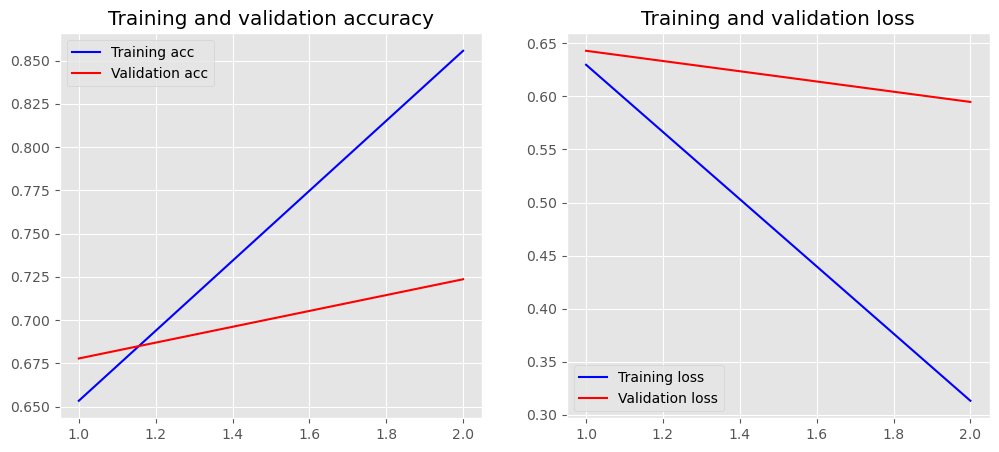

In [25]:
plot_history(history)

## Confusion matrix

In [26]:
encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [27]:
y_pred = model.predict(x_test)
y_pred

74/74 [==============================] - 0s 5ms/step


array([[0.8421693 , 0.96430004, 0.00135513],
       [0.85573894, 0.6833707 , 0.0347217 ],
       [0.9633936 , 0.57732654, 0.00926566],
       ...,
       [0.9367269 , 0.8575863 , 0.00272802],
       [0.96448123, 0.82591593, 0.00172613],
       [0.9665909 , 0.7151893 , 0.00378835]], dtype=float32)

In [28]:
#y_predDecoded = [encoder.classes_[np.argmax(i)] for i in y_pred]  
#cm = confusion_matrix(y_test_nn, y_predDecoded, labels=test.sentiment.unique())  # same confusion matrix code as in Logistic Regression
#df_cm = pd.DataFrame(cm, index=test.sentiment.unique(), columns=test.sentiment.unique())
#df_cm

y_predDecoded = [encoder.classes_[np.argmax(i)] for i in y_pred] # here we get the max probability from those arrays and then based on that select which class is it.
test_loss, test_accuracy = model.evaluate(x_test, dummy_y_test, verbose=False)
print('....')
print("-"*80)
print('Accuracy: %.2f' %(test_accuracy*100),'%')

#precision and recall
print('Precision: %.2f' %(precision_score(y_test_nn, y_predDecoded, average='weighted')*100),'%')
print('Recall: %.2f' %(recall_score(y_test_nn, y_predDecoded, average='weighted')*100),'%')

#confusion matrix on test set
cm = confusion_matrix(y_test_nn, y_predDecoded, labels=test.sentiment.unique()) # same confusion matrix code as in Logistic Regression
confusionMatrix_df = pd.DataFrame(cm, index=test.sentiment.unique(), \
                                  columns=['predicted neutral','predicted negative','predicted positive'])
print ("-"*80)
print ("Confusion Matrix\n")
print (confusionMatrix_df)
print ("-"*80)

....
--------------------------------------------------------------------------------
Accuracy: 72.20 %
Precision: 71.74 %
Recall: 72.20 %
--------------------------------------------------------------------------------
Confusion Matrix

          predicted neutral  predicted negative  predicted positive
neutral                 448                 417                   0
negative                214                1249                   1
positive                  9                  16                   9
--------------------------------------------------------------------------------
